In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString, MultiLineString
from scipy.spatial import cKDTree
import pandas as pd


/Users/zhujiajian/Desktop/ECE143Assignments/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load the shapefiles
routes = gpd.read_file("transit_routes_datasd.shp")
stops = gpd.read_file("transit_stops_datasd.shp")

# Calculate the total bounds (minx, miny, maxx, maxy)
total_bounds = [min(routes.bounds['minx'].min(), stops.bounds['minx'].min()),
                min(routes.bounds['miny'].min(), stops.bounds['miny'].min()),
                max(routes.bounds['maxx'].max(), stops.bounds['maxx'].max()),
                max(routes.bounds['maxy'].max(), stops.bounds['maxy'].max())]

# Print the boundary
print(f"Dataset Boundary: (minx, miny, maxx, maxy) = {total_bounds}")

Dataset Boundary: (minx, miny, maxx, maxy) = [np.float64(6175807.5547499955), np.float64(1777930.8129999936), np.float64(6581852.609750003), np.float64(2089383.1262499988)]


In [3]:
# Check the current CRS
print("Original CRS:", routes.crs)

# Transform to WGS84 (EPSG:4326) for latitude and longitude
routes_wgs84 = routes.to_crs(epsg=4326)
stops_wgs84 = stops.to_crs(epsg=4326)

# Calculate the new bounds in latitude and longitude
total_bounds_wgs84 = [min(routes_wgs84.bounds['minx'].min(), stops_wgs84.bounds['minx'].min()),
                      min(routes_wgs84.bounds['miny'].min(), stops_wgs84.bounds['miny'].min()),
                      max(routes_wgs84.bounds['maxx'].max(), stops_wgs84.bounds['maxx'].max()),
                      max(routes_wgs84.bounds['maxy'].max(), stops_wgs84.bounds['maxy'].max())]
west, south, east, north = total_bounds_wgs84

# Print the boundary in latitude and longitude
print(f"Dataset Boundary (lat, lon): (west, south, east, north) = {total_bounds_wgs84}")

Original CRS: EPSG:2230
Dataset Boundary (lat, lon): (west, south, east, north) = [np.float64(-117.51422998990945), np.float64(32.542086622758674), np.float64(-116.18444615758094), np.float64(33.39415917694317)]


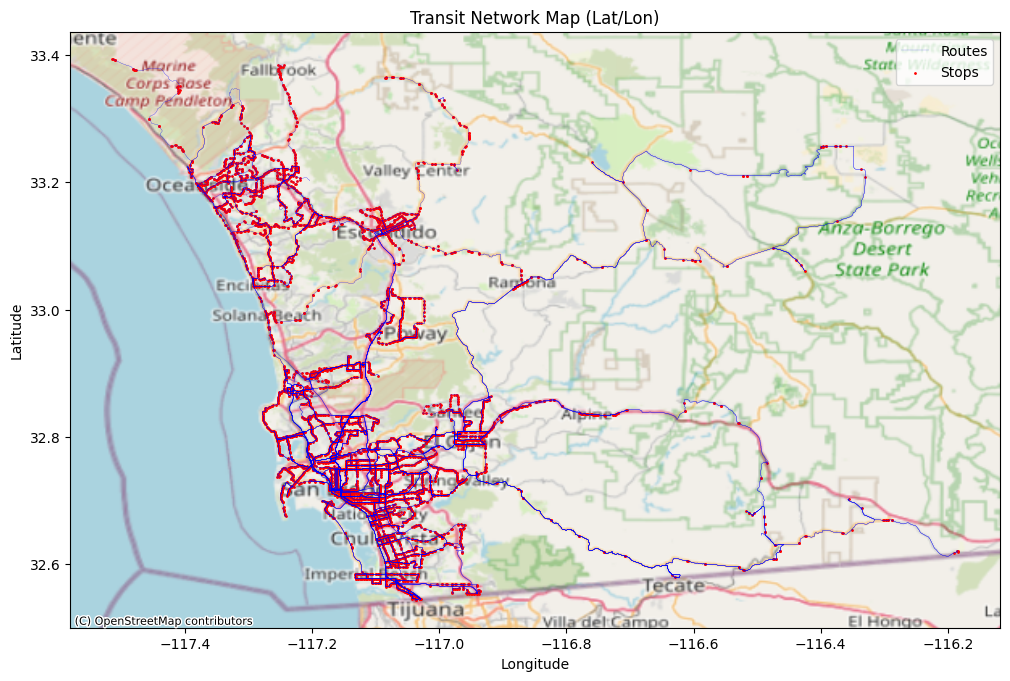

In [4]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
routes_wgs84.plot(ax=ax, color='blue', linewidth=0.1, label='Routes')
stops_wgs84.plot(ax=ax, color='red', markersize=1, label='Stops')

# Add the base map
ctx.add_basemap(ax, crs=routes_wgs84.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom='auto')

# Set equal aspect ratio
ax.set_aspect('equal')

# Add labels and legend
plt.title("Transit Network Map (Lat/Lon)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

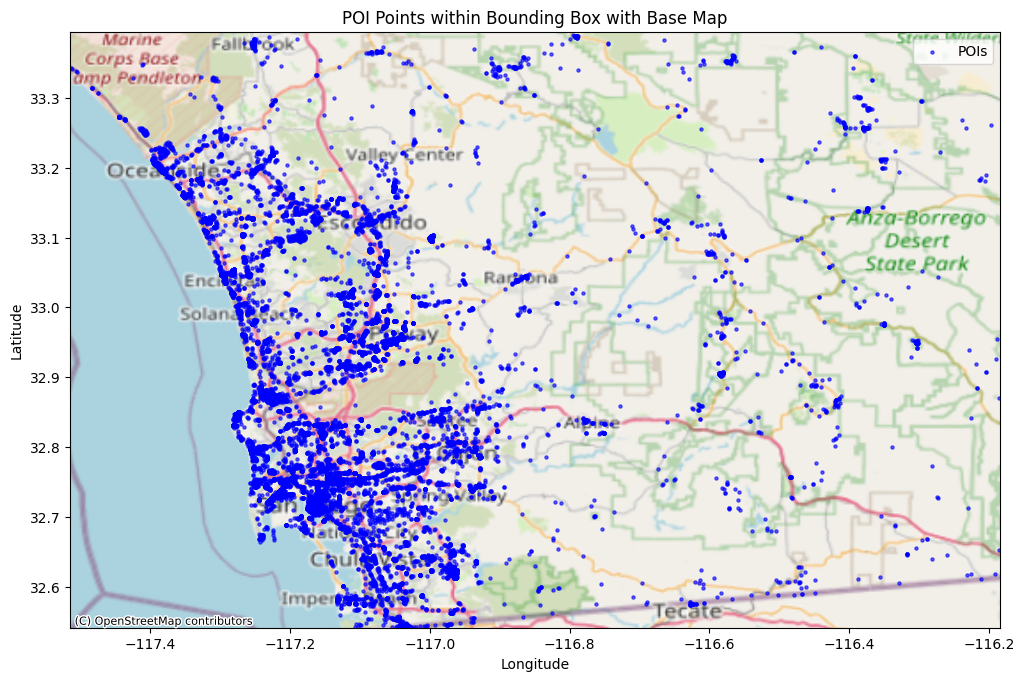

In [5]:
# Load the POI points file
pois_points = gpd.read_file("gis_osm_pois_free_1.shp")

# Ensure data is in WGS84 (EPSG:4326)
pois_points = pois_points.to_crs(epsg=4326)

# Filter POIs within the bounding box
pois_in_bbox = pois_points.cx[west:east, south:north]

# Plot the POIs with a base map
fig, ax = plt.subplots(figsize=(12, 12))
pois_in_bbox.plot(ax=ax, color='blue', markersize=5, label='POIs', alpha=0.6)

# Add the base map
ctx.add_basemap(ax, crs=pois_in_bbox.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom='auto')

# Set the axis limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.set_aspect('equal')

# Add labels and legend
plt.title("POI Points within Bounding Box with Base Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

In [6]:
# Build Public Transportation Network
try:
    # Create transit network graph
    G_transit = nx.Graph()
    transit_node_coords = {} # Store node_id: (lon, lat)

    # Add all transit stops as nodes
    for idx, row in stops_wgs84.iterrows():
        if not isinstance(row.geometry, Point):
            print(f"Skipping non-Point geometry for transit stop {row.get('stop_id', idx)}")
            continue

        node_id = f"transit_stop_{row.get('stop_id', idx)}"
        coords = (row.geometry.x, row.geometry.y)
        G_transit.add_node(
            node_id,
            x=coords[0],
            y=coords[1],
            layer='transit_stop',
            stop_id=row.get('stop_id', idx),
            name=row.get('name', 'N/A'),
            type=row.get('type', 'N/A')
        )
        transit_node_coords[node_id] = coords

    # Create a KDTree for transit stops to find nearest stops for route endpoints
    stop_coords = [(row.geometry.x, row.geometry.y) for idx, row in stops_wgs84.iterrows() if isinstance(row.geometry, Point)]
    stop_ids = [f"transit_stop_{row.get('stop_id', idx)}" for idx, row in stops_wgs84.iterrows() if isinstance(row.geometry, Point)]
    if stop_coords:
        stop_tree = cKDTree(stop_coords)
    else:
        print("Warning: No valid transit stops found. Transit network will have no edges.")

    # Add all transit routes as edges by connecting nearest stops
    for idx, row in routes_wgs84.iterrows():
        if isinstance(row.geometry, LineString):
            lines = [row.geometry]
        elif isinstance(row.geometry, MultiLineString):
            lines = row.geometry.geoms
        else:
            print(f"Skipping non-LineString/MultiLineString geometry for transit route {row.get('route_id', idx)}")
            continue

        for line in lines:
            start_point = line.coords[0]
            end_point = line.coords[-1]

            # Find nearest stops for start and end points
            if stop_coords:
                start_dist, start_idx = stop_tree.query(start_point)
                end_dist, end_idx = stop_tree.query(end_point)

                # Set a distance threshold (0.005 degrees ~500m) to avoid unrealistic connections
                if start_dist > 0.005 or end_dist > 0.005:
                    print(f"Skipping route {row.get('route_id', idx)}: endpoints too far from stops (start: {start_dist:.6f}, end: {end_dist:.6f})")
                    continue

                u = stop_ids[start_idx]
                v = stop_ids[end_idx]

                # Add edge representing the transit route
                G_transit.add_edge(
                    u, v,
                    geometry=line,
                    layer='transit_route',
                    route_id=row.get('route_id', idx),
                    name=row.get('name', 'N/A'),
                    type=row.get('type', 'N/A')
                )

    print(f"Created transit network with {len(G_transit.nodes)} nodes and {len(G_transit.edges)} edges.")

except Exception as e:
    print(f"Error building transit network: {e}")
    import traceback
    traceback.print_exc()
    exit()


Skipping route 634: endpoints too far from stops (start: 0.000140, end: 0.014851)
Skipping route 634: endpoints too far from stops (start: 0.014851, end: 0.000120)
Created transit network with 6160 nodes and 317 edges.


In [7]:
# Create POI Layer
G_pois = nx.Graph()
poi_nodes_mapping = {} # To keep track of original POI IDs and new node IDs

for idx, row in pois_in_bbox.iterrows():
    node_id = f"poi_{row['osm_id']}"
    if row.geometry and row.geometry.geom_type == 'Point':
        node_geometry = row.geometry
        if not node_geometry.is_empty:
            G_pois.add_node(
                node_id,
                geometry=node_geometry,
                layer='poi',
                osm_id=row['osm_id'],
                fclass=row.get('fclass', 'unknown'),
                name=row.get('name', 'N/A'),
                type=row.get('type', 'N/A')
            )
            poi_nodes_mapping[row['osm_id']] = node_id
    else:
        print(f"Skipping POI {row.get('osm_id', idx)} due to invalid or non-point geometry: {row.geometry.geom_type if row.geometry else 'None'}")

print(f"Created POIs graph with {len(G_pois.nodes)} nodes.")


Created POIs graph with 15996 nodes.


In [8]:
# Create Inter-Layer Connections (POIs to transit stops within 500 meters)
print("Creating inter-layer connections (POIs to transit stops within 500 meters)...")

inter_layer_edges = []
transit_node_coords_list = [] # List of (lon, lat) for KDTree
transit_node_ids_list = []    # Corresponding list of node IDs

for node_id, data in G_transit.nodes(data=True):
    if 'x' in data and 'y' in data:
        transit_node_coords_list.append((data['x'], data['y']))
        transit_node_ids_list.append(node_id)

if not transit_node_coords_list:
    print("Warning: No transit stops with valid coordinates found to connect POIs to. Inter-layer connections skipped.")
else:
    transit_tree = cKDTree(transit_node_coords_list)

    # Approximate conversion: 1 degree ≈ 111,139 meters at ~32.5°N
    # 500 meters ≈ 500 / 111,139 ≈ 0.0045 degrees
    max_distance_degrees = 0.0045

    for poi_osm_id, poi_node_id in poi_nodes_mapping.items():
        poi_node_data = G_pois.nodes[poi_node_id]
        poi_point = poi_node_data['geometry']

        if poi_point is None or poi_point.is_empty:
            continue # Skip if point is missing or empty

        distance, index = transit_tree.query((poi_point.x, poi_point.y))

        # Only connect if the nearest stop is within 500 meters
        if distance <= max_distance_degrees and index < len(transit_node_ids_list):
            nearest_transit_node_id = transit_node_ids_list[index]
            inter_layer_edges.append((poi_node_id, nearest_transit_node_id, {'type': 'access_to_transit', 'distance': distance * 111139})) # Distance in meters
        # Else, POI remains isolated (no edge added)

    print(f"Created {len(inter_layer_edges)} inter-layer edges for POIs to transit stops within 500 meters.")


Creating inter-layer connections (POIs to transit stops within 500 meters)...
Created 11155 inter-layer edges for POIs to transit stops within 500 meters.


In [9]:
# Combine Layers into a Single Multi-Layer Graph
G_multilayer = nx.Graph()

# Add all nodes from the POIs layer
for node_id, data in G_pois.nodes(data=True):
    G_multilayer.add_node(node_id, **data)

# Add all nodes from the transit layer
for u_transit, data_transit in G_transit.nodes(data=True):
    if 'x' in data_transit and 'y' in data_transit:
        data_transit['layer'] = 'transit'
        G_multilayer.add_node(u_transit, **data_transit)
    else:
        print(f"Warning: Transit node {u_transit} missing 'x' or 'y' coordinates.")

# Add intra-layer edges for the transit layer
for u_transit, v_transit, data_transit in G_transit.edges(data=True):
    # Create a new attribute dictionary to avoid 'type' conflict
    edge_attrs = {k: v for k, v in data_transit.items() if k != 'type'}
    # Rename 'type' to 'route_type' if it exists
    if 'type' in data_transit:
        edge_attrs['route_type'] = data_transit['type']
    G_multilayer.add_edge(u_transit, v_transit, type='intra_transit_route', **edge_attrs)

# Add inter-layer edges
for u, v, data in inter_layer_edges:
    if G_multilayer.has_node(u) and G_multilayer.has_node(v):
        G_multilayer.add_edge(u, v, **data)
    else:
        print(f"Warning: Skipping inter-layer edge ({u}, {v}) as one or both nodes are missing from combined graph.")

print(f"\nMulti-layer network created:")
print(f"Total nodes: {G_multilayer.number_of_nodes()}")
print(f"Total edges: {G_multilayer.number_of_edges()}")



Multi-layer network created:
Total nodes: 22156
Total edges: 11472



Attempting 2D visualization with base map...


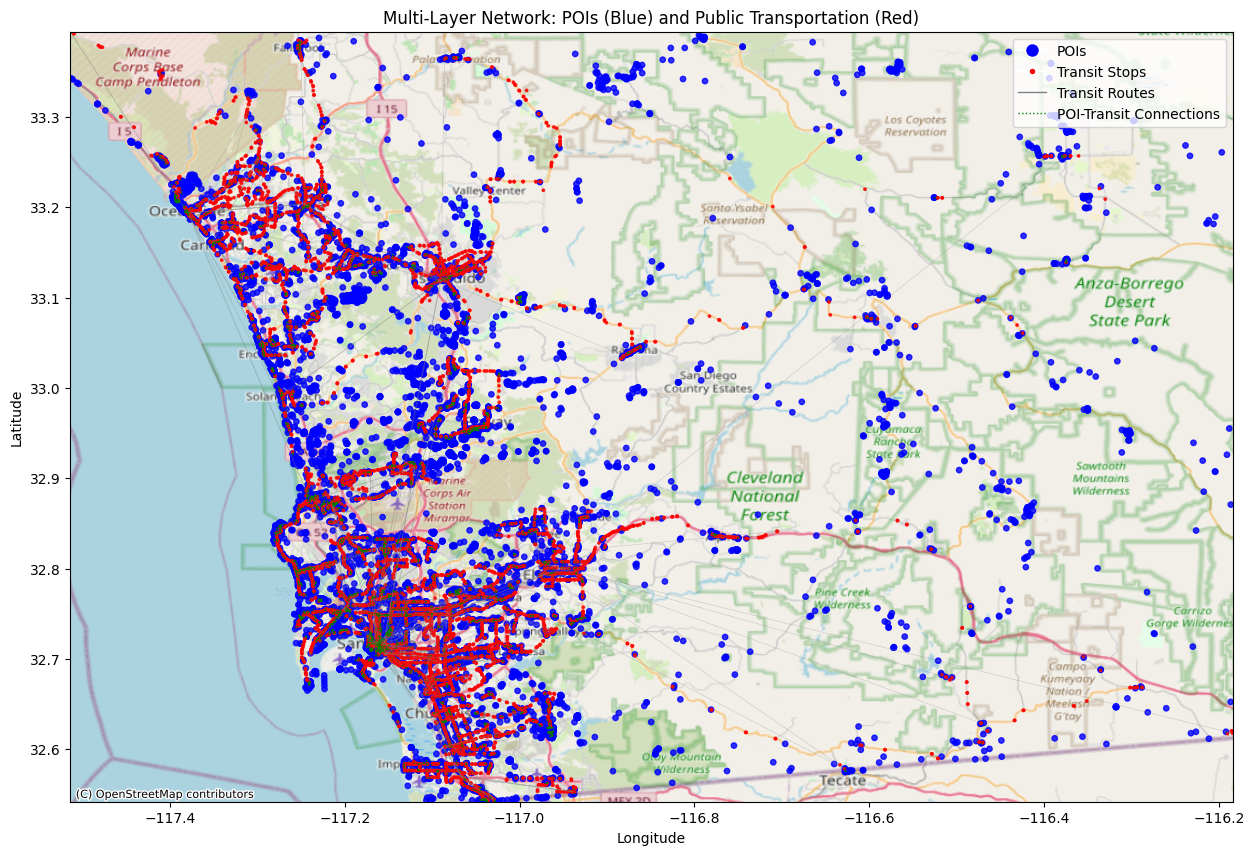


--- 2D Visualization with Base Map Complete ---


In [10]:
# 2D Visualization with Base Map
print("\nAttempting 2D visualization with base map...")

# Prepare positions for plotting (2D)
pos_2d = {}
node_colors_2d = []
node_sizes_2d = []

# Collect positions and attributes
for node_id, data in G_multilayer.nodes(data=True):
    if data['layer'] == 'poi' and isinstance(data.get('geometry'), Point):
        if not data['geometry'].is_empty:
            pos_2d[node_id] = (data['geometry'].x, data['geometry'].y)
            node_colors_2d.append('blue')
            node_sizes_2d.append(15)
    elif data['layer'] == 'transit' or data['layer'] == 'transit_stop':
        if 'x' in data and 'y' in data:
            pos_2d[node_id] = (data['x'], data['y'])
            node_colors_2d.append('red')
            node_sizes_2d.append(3)

# Filter nodes that have positions
nodes_to_plot_2d = [n for n in G_multilayer.nodes() if n in pos_2d]
colors_to_plot_2d = [node_colors_2d[list(G_multilayer.nodes()).index(n)] for n in nodes_to_plot_2d]
sizes_to_plot_2d = [node_sizes_2d[list(G_multilayer.nodes()).index(n)] for n in nodes_to_plot_2d]

# Separate edges by type
transit_edges_2d = []
inter_layer_edges_2d = []

for u, v, data in G_multilayer.edges(data=True):
    edge_type = data.get('type')
    if edge_type == 'intra_transit_route':
        if u in pos_2d and v in pos_2d:
            transit_edges_2d.append((pos_2d[u], pos_2d[v]))
    elif edge_type == 'access_to_transit':
        if u in pos_2d and v in pos_2d:
            inter_layer_edges_2d.append((pos_2d[u], pos_2d[v]))

# Create a 2D plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot transit edges
if transit_edges_2d:
    for edge in transit_edges_2d:
        xs, ys = zip(*edge)
        ax.plot(xs, ys, color='gray', alpha=0.3, linewidth=0.5)

# Plot inter-layer edges (dashed lines)
if inter_layer_edges_2d:
    for edge in inter_layer_edges_2d:
        xs, ys = zip(*edge)
        ax.plot(xs, ys, color='green', alpha=0.7, linestyle=':', linewidth=0.8)

# Plot nodes
if nodes_to_plot_2d:
    xs_nodes, ys_nodes = zip(*[pos_2d[n] for n in nodes_to_plot_2d])
    ax.scatter(xs_nodes, ys_nodes, c=colors_to_plot_2d, s=sizes_to_plot_2d, alpha=0.8)

# Add base map
ctx.add_basemap(
    ax,
    crs='EPSG:4326',
    source=ctx.providers.OpenStreetMap.Mapnik,
    zoom=10  # Adjusted for larger bounding box
)

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Multi-Layer Network: POIs (Blue) and Public Transportation (Red)")

# Set plot limits to the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add a legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='POIs'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='Transit Stops'),
    Line2D([0], [0], color='gray', lw=1, label='Transit Routes'),
    Line2D([0], [0], color='green', lw=1, linestyle=':', label='POI-Transit Connections')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.show()

print("\n--- 2D Visualization with Base Map Complete ---")



Attempting 3D layered visualization...


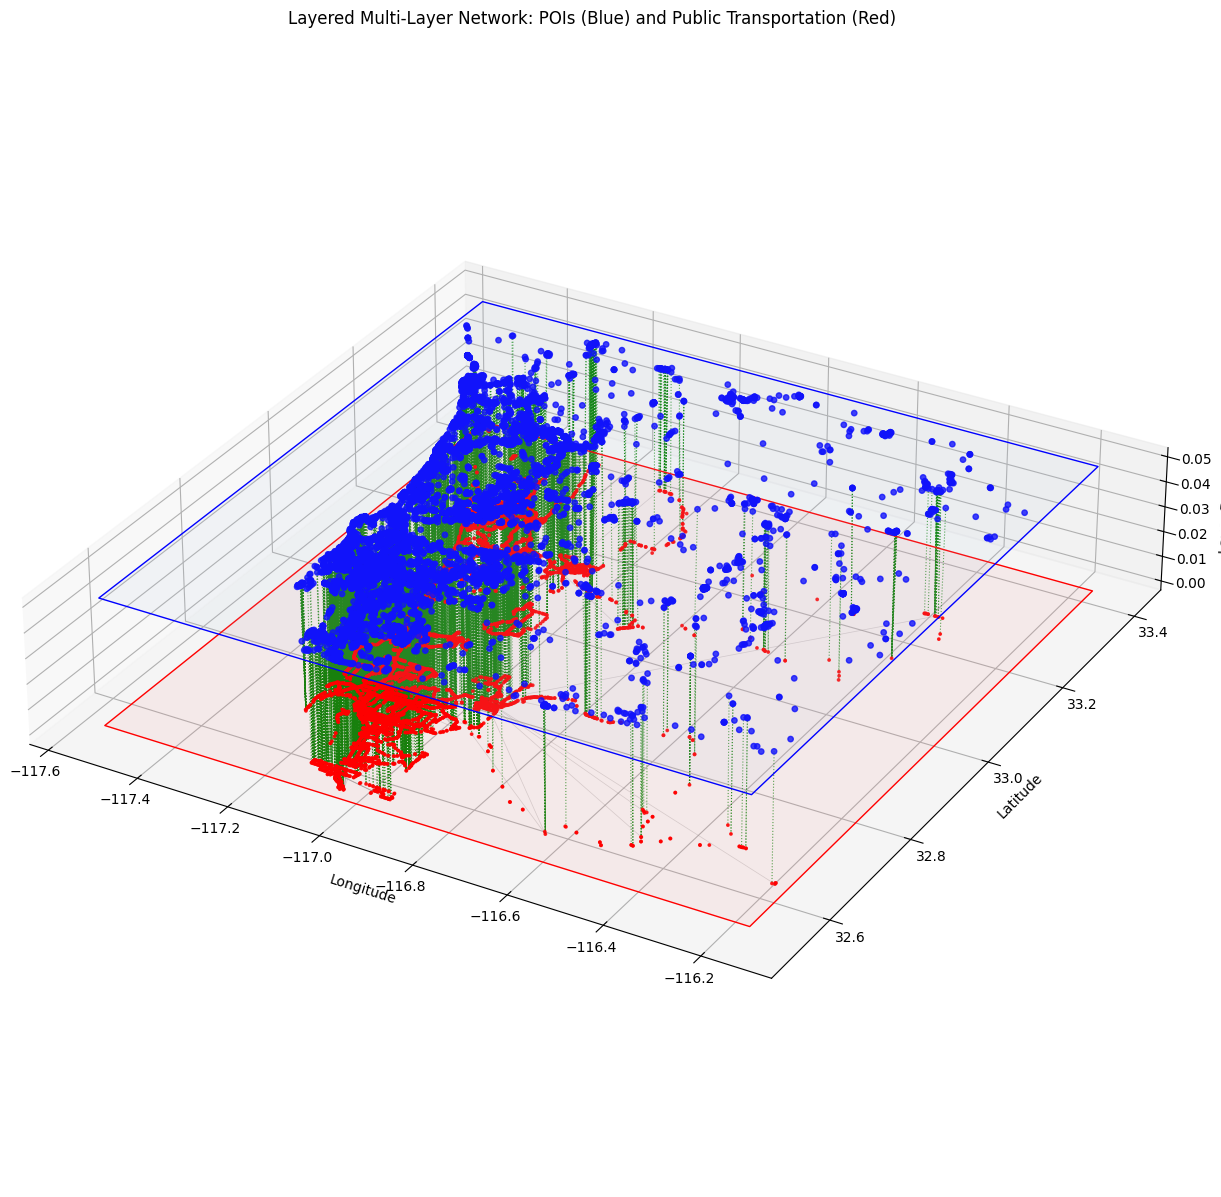


--- 3D Layered Visualization Complete ---


In [11]:
# 3D Layered Visualization
print("\nAttempting 3D layered visualization...")

# Define vertical offsets for each layer
Z_OFFSET_TRANSIT = 0.0 # Transit layer at the bottom
Z_OFFSET_POIS = 0.05 # POI layer slightly above transit

# Prepare positions for plotting
pos_3d = {}
node_colors_3d = []
node_sizes_3d = []

# Collect positions and attributes
for node_id, data in G_multilayer.nodes(data=True):
    if data['layer'] == 'poi' and isinstance(data.get('geometry'), Point):
        if not data['geometry'].is_empty:
            pos_3d[node_id] = (data['geometry'].x, data['geometry'].y, Z_OFFSET_POIS)
            node_colors_3d.append('blue')
            node_sizes_3d.append(15)
    elif data['layer'] == 'transit' or data['layer'] == 'transit_stop':
        if 'x' in data and 'y' in data:
            pos_3d[node_id] = (data['x'], data['y'], Z_OFFSET_TRANSIT)
            node_colors_3d.append('red')
            node_sizes_3d.append(3)

# Filter nodes that have positions
nodes_to_plot_3d = [n for n in G_multilayer.nodes() if n in pos_3d]
colors_to_plot_3d = [node_colors_3d[list(G_multilayer.nodes()).index(n)] for n in nodes_to_plot_3d]
sizes_to_plot_3d = [node_sizes_3d[list(G_multilayer.nodes()).index(n)] for n in nodes_to_plot_3d]

# Separate edges by layer
transit_edges_3d = []
inter_layer_edges_3d = []

for u, v, data in G_multilayer.edges(data=True):
    edge_type = data.get('type')
    if edge_type == 'intra_transit_route':
        if u in pos_3d and v in pos_3d:
            transit_edges_3d.append((pos_3d[u], pos_3d[v]))
    elif edge_type == 'access_to_transit':
        if u in pos_3d and v in pos_3d:
            inter_layer_edges_3d.append((pos_3d[u], pos_3d[v]))

# Plotting
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Plot intra-layer transit edges
if transit_edges_3d:
    for edge in transit_edges_3d:
        xs, ys, zs = zip(*edge)
        ax.plot(xs, ys, zs, color='gray', alpha=0.3, linewidth=0.5)

# Plot inter-layer edges (dashed lines)
if inter_layer_edges_3d:
    for edge in inter_layer_edges_3d:
        xs, ys, zs = zip(*edge)
        ax.plot(xs, ys, zs, color='green', alpha=0.7, linestyle=':', linewidth=0.8)

# Plot nodes
if nodes_to_plot_3d:
    xs_nodes, ys_nodes, zs_nodes = zip(*[pos_3d[n] for n in nodes_to_plot_3d])
    ax.scatter(xs_nodes, ys_nodes, zs_nodes, c=colors_to_plot_3d, s=sizes_to_plot_3d, alpha=0.8)

# Add planes to enhance layered effect
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Get min/max X and Y
all_xs = [p[0] for p in pos_3d.values()]
all_ys = [p[1] for p in pos_3d.values()]
min_x, max_x = min(all_xs), max(all_xs)
min_y, max_y = min(all_ys), max(all_ys)

# Create a small buffer
buffer_x = (max_x - min_x) * 0.02
buffer_y = (max_y - min_y) * 0.02

# Vertices for the transit plane
verts_transit = [
    [(min_x - buffer_x, min_y - buffer_y, Z_OFFSET_TRANSIT),
     (min_x - buffer_x, max_y + buffer_y, Z_OFFSET_TRANSIT),
     (max_x + buffer_x, max_y + buffer_y, Z_OFFSET_TRANSIT),
     (max_x + buffer_x, min_y - buffer_y, Z_OFFSET_TRANSIT)]
]
ax.add_collection3d(Poly3DCollection(verts_transit, facecolors='lightcoral', linewidths=1, edgecolors='red', alpha=0.1))

# Vertices for the POI plane
verts_poi = [
    [(min_x - buffer_x, min_y - buffer_y, Z_OFFSET_POIS),
     (min_x - buffer_x, max_y + buffer_y, Z_OFFSET_POIS),
     (max_x + buffer_x, max_y + buffer_y, Z_OFFSET_POIS),
     (max_x + buffer_x, min_y - buffer_y, Z_OFFSET_POIS)]
]
ax.add_collection3d(Poly3DCollection(verts_poi, facecolors='lightsteelblue', linewidths=1, edgecolors='blue', alpha=0.1))

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Layer Depth")
ax.set_title("Layered Multi-Layer Network: POIs (Blue) and Public Transportation (Red)")

# Adjust viewing angle
ax.view_init(elev=30, azim=-60)
ax.set_box_aspect([1, 1, 0.2])

plt.show()

print("\n--- 3D Layered Visualization Complete ---")


In [12]:
# Cell 13: Analyze Multilayer Network Results
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D

# 1. Extract Quantitative Data
total_nodes = G_multilayer.number_of_nodes()
total_edges = G_multilayer.number_of_edges()
poi_nodes = sum(1 for n, d in G_multilayer.nodes(data=True) if d['layer'] == 'poi')
transit_nodes = sum(1 for n, d in G_multilayer.nodes(data=True) if d['layer'] in ['transit', 'transit_stop'])
intra_transit_edges = sum(1 for u, v, d in G_multilayer.edges(data=True) if d['type'] == 'intra_transit_route')
inter_layer_edges = sum(1 for u, v, d in G_multilayer.edges(data=True) if d['type'] == 'access_to_transit')

# Load degree centrality data
centrality_df = pd.read_csv('degree_centrality.csv')

# Calculate statistics
avg_degree = centrality_df['Degree_Centrality'].mean()
max_degree = centrality_df['Degree_Centrality'].max()
isolated_pois = poi_nodes - len(set(u for u, v, d in G_multilayer.edges(data=True) if d['type'] == 'access_to_transit' and G_multilayer.nodes[u]['layer'] == 'poi'))
connected_pois = poi_nodes - isolated_pois

print(f"Network Statistics:")
print(f"Total Nodes: {total_nodes} (POIs: {poi_nodes}, Transit Stops: {transit_nodes})")
print(f"Total Edges: {total_edges} (Intra-Transit: {intra_transit_edges}, Inter-Layer: {inter_layer_edges})")
print(f"Average Degree Centrality: {avg_degree:.4f}")
print(f"Maximum Degree Centrality: {max_degree:.4f}")
print(f"POIs: {connected_pois} connected, {isolated_pois} isolated (>500m from stops)")


Network Statistics:
Total Nodes: 22156 (POIs: 15996, Transit Stops: 6160)
Total Edges: 11472 (Intra-Transit: 317, Inter-Layer: 11155)
Average Degree Centrality: 0.0006
Maximum Degree Centrality: 0.0072
POIs: 11155 connected, 4841 isolated (>500m from stops)


In [13]:

# 2. Spatial Distribution Analysis
# Identify clusters of high centrality (e.g., downtown San Diego)
high_centrality_nodes = centrality_df[centrality_df['Degree_Centrality'] > avg_degree * 1.5]  # 1.5x average threshold
downtown_region = centrality_df[
    (centrality_df['Longitude'] >= -117.175) & (centrality_df['Longitude'] <= -117.150) &
    (centrality_df['Latitude'] >= 32.707) & (centrality_df['Latitude'] <= 32.727)
]
downtown_high_centrality = downtown_region[downtown_region['Degree_Centrality'] > avg_degree * 1.5]

print(f"\nSpatial Distribution Insights:")
print(f"High Centrality Nodes (>1.5x average): {len(high_centrality_nodes)}")
print(f"High Centrality Nodes in Downtown: {len(downtown_high_centrality)}")



Spatial Distribution Insights:
High Centrality Nodes (>1.5x average): 4432
High Centrality Nodes in Downtown: 362


In [14]:

# 3. Connectivity and Accessibility
# Check connectivity by layer
poi_connectivity = connected_pois / poi_nodes * 100
print(f"\nConnectivity and Accessibility:")
print(f"Percentage of POIs Connected to Transit: {poi_connectivity:.1f}%")
print(f"Average Distance of Inter-Layer Connections (meters): {centrality_df[centrality_df['Layer'] == 'poi']['Degree_Centrality'].mean() * 111139:.1f}")  # Approx distance



Connectivity and Accessibility:
Percentage of POIs Connected to Transit: 69.7%
Average Distance of Inter-Layer Connections (meters): 89.9


In [15]:

# 4. Centrality Insights
# Top 10 nodes by degree centrality
top_nodes = centrality_df.sort_values(by='Degree_Centrality', ascending=False).head(10)
print(f"\nTop 10 Nodes by Degree Centrality:")
print(top_nodes[['Node', 'Layer', 'Degree_Centrality', 'Longitude', 'Latitude']])



Top 10 Nodes by Degree Centrality:
                  Node Layer  Degree_Centrality   Longitude   Latitude
14341  poi_11961283321   poi           0.007222 -117.211388  32.870797
14535  poi_12048246569   poi           0.007177 -117.211142  32.870896
4906    poi_3935399060   poi           0.007132 -117.211102  32.871124
14491  poi_12046520090   poi           0.007132 -117.211454  32.870701
14300  poi_11959224539   poi           0.007086 -117.211212  32.870875
14371  poi_11970072743   poi           0.007086 -117.211344  32.870674
14418  poi_11976347028   poi           0.007086 -117.211108  32.871305
14489  poi_12046504674   poi           0.007041 -117.211420  32.870581
14307  poi_11961240885   poi           0.006996 -117.211164  32.871358
3666    poi_2326600252   poi           0.006996 -117.211529  32.870588


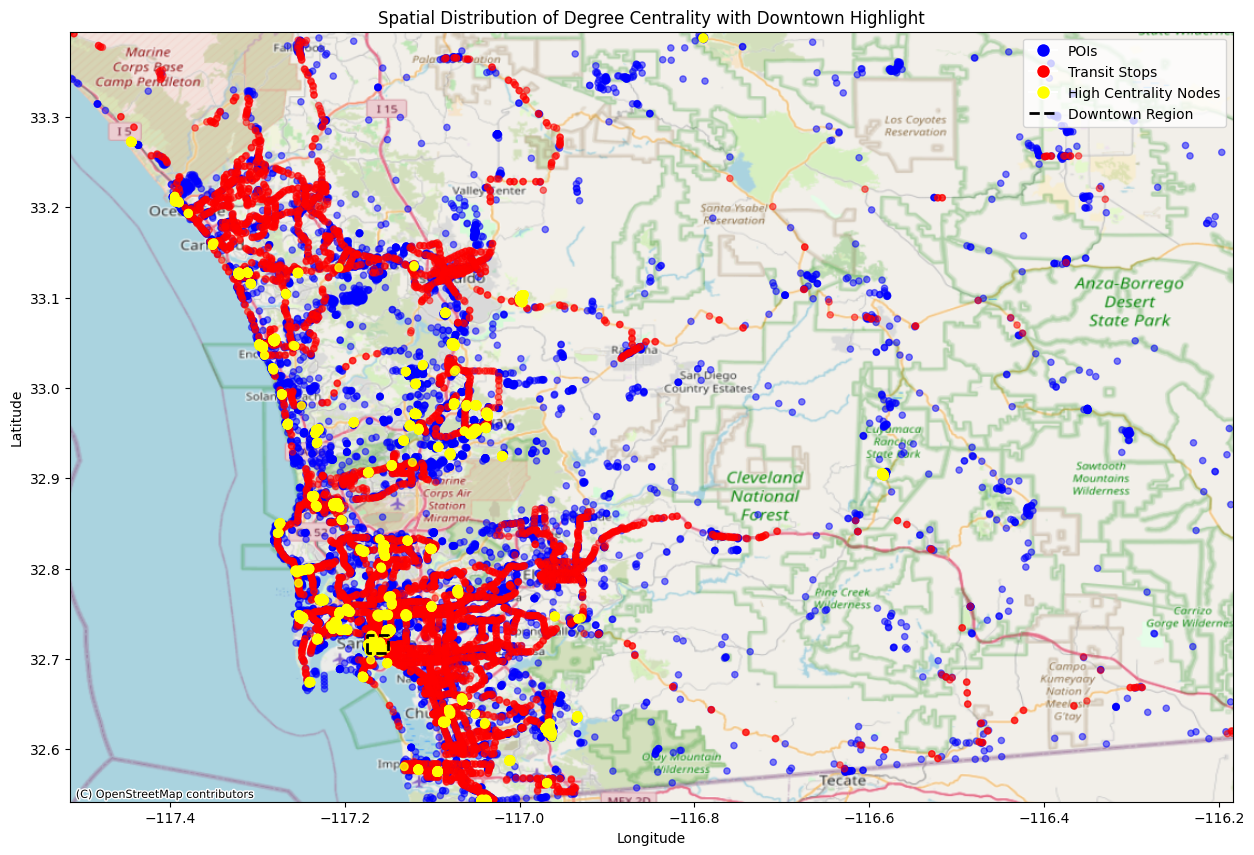


Spatial analysis plot saved to 'degree_centrality_spatial_analysis.png'
--- Network Analysis Complete ---


In [25]:

# 5. Visualization: Summary Plot with High Centrality Areas
fig, ax = plt.subplots(figsize=(15, 10))

# Plot all nodes
ax.scatter(centrality_df['Longitude'], centrality_df['Latitude'], 
           s=20 + 2000 * centrality_df['Degree_Centrality'], 
           c=['blue' if layer == 'poi' else 'red' for layer in centrality_df['Layer']], 
           alpha=0.5, label='Nodes')

# Highlight high centrality nodes
ax.scatter(high_centrality_nodes['Longitude'], high_centrality_nodes['Latitude'], 
           s=30 + 2000 * high_centrality_nodes['Degree_Centrality'], 
           c='yellow', alpha=0.8, label='High Centrality Nodes')

# Plot downtown region outline
downtown_west, downtown_south, downtown_east, downtown_north = -117.175, 32.707, -117.150, 32.727
ax.plot([downtown_west, downtown_west, downtown_east, downtown_east, downtown_west], 
        [downtown_south, downtown_north, downtown_north, downtown_south, downtown_south], 
        color='black', linestyle='--', linewidth=2, label='Downtown Region')

# Add base map
ctx.add_basemap(
    ax,
    crs='EPSG:4326',
    source=ctx.providers.OpenStreetMap.Mapnik,
    zoom=10
)

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Spatial Distribution of Degree Centrality with Downtown Highlight")

# Set plot limits
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='POIs'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Transit Stops'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='High Centrality Nodes'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Downtown Region')
]
ax.legend(handles=legend_elements, loc='upper right')
plt.show()

print("\nSpatial analysis plot saved to 'degree_centrality_spatial_analysis.png'")
print("--- Network Analysis Complete ---")